<a href="https://colab.research.google.com/github/follimatteo/LearningPyTorch/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [188]:
import torch
import torchvision
from torchvision.transforms import transforms

import matplotlib.pyplot as plt
import torch.nn.functional as F

In [19]:
torch.cuda.is_available()

False

In [30]:
data_train = torchvision.datasets.MNIST("/data/", train = True, download=True, transform=transforms.ToTensor())
data_test = torchvision.datasets.MNIST("/data/", train = False, download=True, transform=transforms.ToTensor())

classes = data_train.classes
data_train, classes

(Dataset MNIST
     Number of datapoints: 60000
     Root location: /data/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'])

<class 'tuple'>
<class 'torch.Tensor'>
torch.Size([1, 28, 28])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])




Label:  5


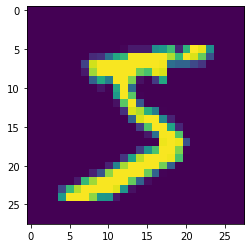

In [75]:
# Dataset exploration 
print(type(data_train[0]))
print(type(data_train[0][0]))
print(data_train[0][0].shape)
print(data_train[0][0][0][0])
print("\n")
print("\n")
print("Label: ", data_train[0][1])
plt.imshow(data_train[0][0].view(28,28));

In [250]:
def tensor2matrix(dset, limit=-1):
  x = dset.data[:limit].clone().detach().float().div_(255)
  x = x.reshape((x.shape[0], -1))
  y = dset.targets[:limit].clone().detach()
  return x, y

x_train, y_train = tensor2matrix(data_train, limit = 10000)
x_valid, y_valid = tensor2matrix(data_test, limit = 1000 )
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

torch.Size([10000, 784])
torch.Size([10000])
torch.Size([1000, 784])
torch.Size([1000])


In [263]:
### Linear classifier
class Lin ():
  def __init__(self, shape, lr, loss):
    self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.W = torch.rand(shape, requires_grad=True)
    self.b = torch.rand(shape[-1], requires_grad=True)
    
    self.lr = lr
    self.loss = loss
    #print("W: ",self.W.shape)
    #print("b: ",self.b.shape)


  def __call__(self, x):
    return torch.matmul(x, self.W) + self.b

  def train(self, x, y, x_valid, y_valid, epochs, step = 0):

    for e in range(epochs+1):
      
      scores = self.__call__(x)
      l = self.loss(scores, y)
      l.backward()
      
      acc = accuracy(scores, y)
      with torch.no_grad():
        # compute validation loss and metrics
        valid_scores = self.__call__(x_valid)
        valid_loss = F.cross_entropy(valid_scores, y_valid).item()
        valid_acc = accuracy(valid_scores, y_valid).item()

        self.W -= self.lr * self.W.grad
        self.b -= self.lr * self.b.grad

        self.W.grad.zero_()
        self.b.grad.zero_()
      
      if e % 100 == 0:
        print(f"Epoch {e}: train loss {l:.3f} - train acc {acc:.3f} - valid loss {valid_loss:.3f} - valid acc {valid_acc:.3f}")

      


In [236]:
def accuracy(scores, y):
  y_hat = torch.argmax(scores, -1)
  correct = (y_hat==y).sum()
  return correct.true_divide(y.shape[0])

In [230]:
### random classifier
lin = Lin((28*28,10), 0, None)
out = lin(x_train)
acc = accuracy(out, y_train)
print(acc)

tensor(0.0800)


In [262]:
### TRAIN 
lin = Lin((28*28,10), 0.1, F.cross_entropy)
lin.train(x_train, y_train, x_valid, y_valid, 2000, 0)

Epoch 0: train loss 4.710 - train acc 0.085 - valid loss 4.139 - valid acc 0.088
Epoch 100: train loss 1.434 - train acc 0.659 - valid loss 1.361 - valid acc 0.648
Epoch 200: train loss 1.003 - train acc 0.748 - valid loss 1.133 - valid acc 0.699
Epoch 300: train loss 0.977 - train acc 0.804 - valid loss 1.002 - valid acc 0.787
Epoch 400: train loss 0.911 - train acc 0.844 - valid loss 1.021 - valid acc 0.806
Epoch 500: train loss 1.113 - train acc 0.832 - valid loss 1.062 - valid acc 0.820
Epoch 600: train loss 1.070 - train acc 0.855 - valid loss 1.198 - valid acc 0.836
Epoch 700: train loss 1.017 - train acc 0.873 - valid loss 1.189 - valid acc 0.846
Epoch 800: train loss 1.195 - train acc 0.865 - valid loss 1.426 - valid acc 0.837
Epoch 900: train loss 1.193 - train acc 0.862 - valid loss 1.432 - valid acc 0.837
Epoch 1000: train loss 1.211 - train acc 0.876 - valid loss 1.592 - valid acc 0.839
Epoch 1100: train loss 1.174 - train acc 0.893 - valid loss 1.615 - valid acc 0.859
Epoc

In [271]:
### Linear classifier, ADDING OPTIMIZERS
class Lin ():
  def __init__(self, shape, lr, loss, opti='default'):
    self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.W = torch.rand(shape, requires_grad=True)
    self.b = torch.rand(shape[-1], requires_grad=True)
    
    self.loss = loss
    self.opti = torch.optim.Adam([self.W, self.b]) if opti == 'default' else opti([self.W,self.b])
    #print("W: ",self.W.shape)
    #print("b: ",self.b.shape)


  def __call__(self, x):
    return torch.matmul(x, self.W) + self.b

  def train(self, x, y, x_valid, y_valid, epochs, step = 0):
    losses = []
    accuracies = []

    for e in range(epochs+1):
      
      scores = self.__call__(x)
      l = self.loss(scores, y)
      l.backward()
      self.opti.step()

      acc = accuracy(scores, y)
      losses.append(l)
      accuracies.append(acc)
      with torch.no_grad():
        # compute validation loss and metrics
        valid_scores = self.__call__(x_valid)
        valid_loss = F.cross_entropy(valid_scores, y_valid).item()
        valid_acc = accuracy(valid_scores, y_valid).item()

      if e % 100 == 0:
        print(f"Epoch {e}: train loss {l:.3f} - train acc {acc:.3f} - valid loss {valid_loss:.3f} - valid acc {valid_acc:.3f}")
      
    plt.plot(losses)
    plt.plot(accuracies)
    plt.show()

Epoch 0: train loss 4.201 - train acc 0.111 - valid loss 4.001 - valid acc 0.087
Epoch 100: train loss 0.932 - train acc 0.695 - valid loss 1.079 - valid acc 0.662
Epoch 200: train loss 0.662 - train acc 0.825 - valid loss 0.845 - valid acc 0.785


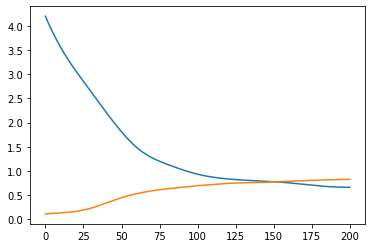

In [272]:
### TRAIN 
lin = Lin((28*28,10), 0.1, F.cross_entropy)
lin.train(x_train, y_train, x_valid, y_valid, 200, 0)